In [0]:
import numpy as np
import math
import pickle
import matplotlib.pyplot as plt
from matplotlib import animation

from tqdm import tqdm

from collections import deque

%matplotlib inline

In [0]:
import cv2

from gym import make, ObservationWrapper, wrappers, Wrapper
from gym.spaces import Box

In [0]:
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import RIGHT_ONLY, COMPLEX_MOVEMENT

env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0')
env = JoypadSpace(env, RIGHT_ONLY)

In [4]:
action_space = env.get_action_meanings()
action_space

['NOOP', 'right', 'right A', 'right B', 'right A B']

In [0]:
from IPython.display import HTML

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim.to_html5_video())

In [0]:
def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    #plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=20)
    display(display_animation(anim))

/usr/local/lib/python3.6/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


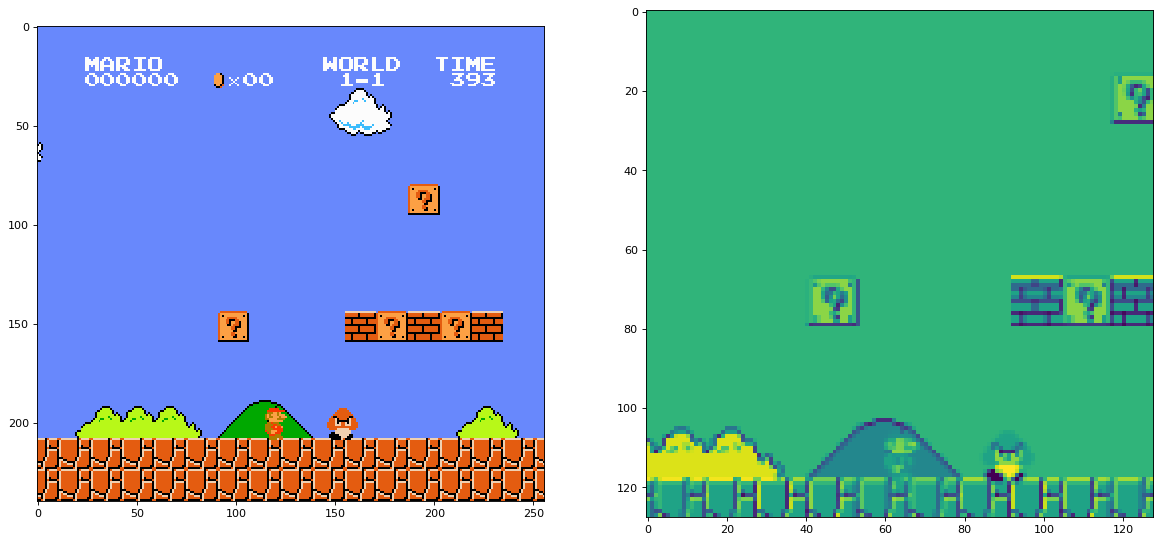

In [7]:
observation = env.reset()
for _  in range(150):
    env.step(1)

fig=plt.figure(figsize=(18, 18), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
plt.imshow(observation)

frame = cv2.cvtColor(observation, cv2.COLOR_RGB2GRAY)
frame = cv2.resize(frame[60:220,40:200], (128, 128), interpolation=cv2.INTER_AREA)
plt.subplot(1, 2, 2)
plt.imshow(frame)

In [0]:
class FrameDownsample(ObservationWrapper):
    def __init__(self, env):
        super(FrameDownsample, self).__init__(env)
        self._width = 128
        self._height = 128
        self.observation_space = Box(low=0,
                                     high=255,
                                     shape=(self._width, self._height, 1),
                                     dtype=np.uint8)

    def observation(self, observation):
        frame = cv2.cvtColor(observation, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame[60:220,40:200],
                           (self._width, self._height),
                           interpolation=cv2.INTER_AREA)
        return frame[:, :, None]

In [0]:
class ImageToPyTorch(ObservationWrapper):
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        obs_shape = self.observation_space.shape
        self.observation_space = Box(low=0.0,
                                     high=1.0,
                                     shape=(obs_shape[::-1]),
                                     dtype=np.float32)

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)

In [0]:
class CustomReward(Wrapper):
    def __init__(self, env):
        super(CustomReward, self).__init__(env)
        self._current_score = 0
        self._x_pos = 0
        self._y_pos = 0

    def step(self, action):
        state, reward, done, info = self.env.step(action)
        
        difference_score = info['score'] - self._current_score
        difference_x = info['x_pos'] - self._x_pos
        difference_y = info['y_pos'] - self._y_pos
        
        if difference_x > 30 or difference_x < 0:
            difference_x = 0
            
        if difference_y < 0:
            difference_y = 0
        if difference_score < 0:
            difference_score = 0
        
#         print(f"Score : {difference_score} | X : {difference_x} | Y : {difference_y}")
        reward = difference_score / 20.0 + difference_x # + difference_y
        
        self._current_score = info['score']
        self._x_pos = info['x_pos']
        self._y_pos = info['y_pos']
        
        if done:
            if info['flag_get']:
                reward += 50.0
            else:
                reward -= 300.0
        
        return state, reward, done, info

In [0]:
class FrameBuffer(ObservationWrapper):
    def __init__(self, env, num_steps, dtype=np.float32):
        super(FrameBuffer, self).__init__(env)
        obs_space = env.observation_space
        self._dtype = dtype
        self.observation_space = Box(obs_space.low.repeat(num_steps, axis=0),
                                     obs_space.high.repeat(num_steps, axis=0),
                                     dtype=self._dtype)

    def reset(self):
        self.buffer = np.zeros_like(self.observation_space.low,
                                    dtype=self._dtype)
        return self.observation(self.env.reset())

    def observation(self, observation):
        self.buffer[:-1] = self.buffer[1:]
        self.buffer[-1] = observation
        return self.buffer

In [0]:
class MaxAndSkipEnv(Wrapper):
    def __init__(self, env=None, skip=4):
        super(MaxAndSkipEnv, self).__init__(env)
        self._obs_buffer = deque(maxlen=2)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        done = None
        for _ in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            self._obs_buffer.append(obs)
            total_reward += reward
            if done:
                break
        max_frame = np.max(np.stack(self._obs_buffer), axis=0)
        return max_frame, total_reward, done, info

    def reset(self):
        self._obs_buffer.clear()
        obs = self.env.reset()
        self._obs_buffer.append(obs)
        return obs

In [0]:
class NormalizeFloats(ObservationWrapper):
    def observation(self, obs):
        return np.array(obs).astype(np.float32) / 255.0

In [14]:
env = MaxAndSkipEnv(env)
env = FrameDownsample(env)
env = ImageToPyTorch(env)
env = FrameBuffer(env, 4)
env = NormalizeFloats(env)
env = CustomReward(env)

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class QNetworkCNN(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, input_shape, num_actions, seed=42):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(QNetworkCNN, self).__init__()
        
        self._input_shape = input_shape
        self._num_actions = num_actions
        
        self.seed = torch.manual_seed(seed)
        
        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=3, stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.fc = nn.Linear(self.feature_size, num_actions)

    def forward(self, x):
        x = self.features(x).view(x.size()[0], -1)
        return self.fc(x)
    
    @property
    def feature_size(self):
        x = self.features(torch.zeros(1, *self._input_shape))
        return x.view(1, -1).size(1)

In [0]:
import torch
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, state_size, action_size, buffer_size, batch_size, priority=False):
        """Initialize a ReplayBuffer object.
        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer (chosen as multiple of num agents)
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.states = torch.zeros((buffer_size,)+state_size).to(device)
        self.next_states = torch.zeros((buffer_size,)+state_size).to(device)
        self.actions = torch.zeros(buffer_size,1, dtype=torch.long).to(device)
        self.rewards = torch.zeros(buffer_size, 1, dtype=torch.float).to(device)
        self.dones = torch.zeros(buffer_size, 1, dtype=torch.float).to(device)
        self.e = np.zeros((buffer_size, 1), dtype=np.float)
        
        self.priority = priority

        self.ptr = 0
        self.n = 0
        self.buffer_size = buffer_size
        self.batch_size = batch_size
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        self.states[self.ptr] = torch.from_numpy(state).to(device)
        self.next_states[self.ptr] = torch.from_numpy(next_state).to(device)
        self.actions[self.ptr] = action
        self.rewards[self.ptr] = reward
        self.dones[self.ptr] = done
        
        self.ptr += 1
        if self.ptr >= self.buffer_size:
            self.ptr = 0
            self.n = self.buffer_size

    def sample(self, get_all=False):
        """Randomly sample a batch of experiences from memory."""
        n = len(self)
        if get_all:
            return self.states[:n], self.actions[:n], self.rewards[:n], self.next_states[:n], self.dones[:n]
        # else:
        if self.priority and self.e.min() > 0:
            probabilities = self.e.squeeze(1)[:n]
            probabilities = probabilities / probabilities.sum()
            idx = np.random.choice(n, self.batch_size, replace=False, p=probabilities)
        else:
            idx = np.random.choice(n, self.batch_size, replace=False)
        
        states = self.states[idx]
        next_states = self.next_states[idx]
        actions = self.actions[idx]
        rewards = self.rewards[idx]
        dones = self.dones[idx]
        
        return (states, actions, rewards, next_states, dones), idx
      
    def update_error(self, e, idx=None):
        e = torch.abs(e.detach())
        if idx is not None:
            self.e[idx] = e.cpu().numpy()
        else:
            self.e[:len(self)] = e.cpu().numpy()
        
    def __len__(self):
        if self.n == 0:
            return self.ptr
        else:
            return self.n

In [0]:
import numpy as np
import random
from collections import namedtuple, deque
import itertools

import torch
import torch.nn.functional as F
import torch.optim as optim

BUFFER_SIZE = int(3e3)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.9             # discount factor
LR = 1e-3               # learning rate

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            

class DQNAgent():
    """Interacts with and learns from the environment."""

    def __init__(self, model, state_size, action_size, seed=42, priority=False):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = model(state_size, action_size, seed).to(device)
        # self.qnetwork_local.load_state_dict(torch.load('model.dat'))
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(state_size, (action_size,), BUFFER_SIZE, BATCH_SIZE, priority)
        
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)

        # If enough samples are available in memory, get random subset and learn
        if len(self.memory) > BATCH_SIZE:
            experiences, idx = self.memory.sample()
            e, loss = self.learn(experiences)
            self.memory.update_error(e, idx)
            return loss

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
          
    def update_error(self):
        states, actions, rewards, next_states, dones = self.memory.sample(get_all=True)
        with torch.no_grad():
            maxQ = self.qnetwork_local(next_states).max(-1, keepdim=True)[0]
            target = rewards+GAMMA*maxQ*(1-dones)
            old_val = self.qnetwork_local(states).gather(-1, actions)
            e = old_val - target
            self.memory.update_error(e)

    def learn(self, experiences):
        """Update value parameters using given batch of experience tuples.
        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        ## compute and minimize the loss
        self.optimizer.zero_grad()
        with torch.no_grad():
            maxQ = self.qnetwork_local(next_states).max(-1, keepdim=True)[0]
            target = rewards+GAMMA*maxQ*(1-dones)
        old_val = self.qnetwork_local(states).gather(-1, actions)
        
        loss = F.mse_loss(old_val, target)
        loss.backward()
        self.optimizer.step()
        
        return old_val - target, loss.cpu().data.numpy()

In [0]:
FRAME_SHAPE = (128, 128)
MAX_FRAMES = 4
    
action_size = len(action_space)
state_size = (MAX_FRAMES,) + FRAME_SHAPE
agent = DQNAgent(QNetworkCNN, state_size, action_size, priority=True)

In [0]:
episode = 100
tmax = 10000

EPSILON_START = 1.0
EPSILON_FINAL = 0.05
EPSILON_DECAY = 50

epsilon = EPSILON_START

# keep track of progress
sum_rewards = []

for e in range(episode):
    obs = env.reset()
    prev_obs = None
    sum_reward = 0
    rewards = []
    losses = []
    
    for t in range(tmax):
        actions = agent.act(obs, epsilon)
        obs, reward, done, info = env.step(actions)
        loss = agent.step(obs, int(actions), int(reward), obs, int(done))
        
        sum_reward += reward
        rewards.append(reward)
        
        if loss is not None:
            losses.append(loss)
        if done or reward < -10:
            break
    
    agent.update_error()
    sum_rewards.append(sum_reward)
    epsilon = EPSILON_FINAL + (EPSILON_START - EPSILON_FINAL) * math.exp(-1 * ((e + 1) / EPSILON_DECAY))
    
    print('\rEpisode {}\tCurrent Score: {:.2f}\tCurrent Epsilon: {:.2f}\tMean loss: {:.2f}      '.format(e, sum_rewards[-1], epsilon, np.mean(losses)), end="")
    # display some progress every 20 iterations
    if (e+1) % 20 == 0:
        print(" | Episode: {0:d}, average score: {1:f}".format(e+1,np.mean(sum_rewards[-20:])))

/usr/local/lib/python3.6/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 2	Current Score: -38.00	Current Epsilon: 0.94	Mean loss: 263.01      

In [0]:
plt.plot(sum_rewards)
plt.show()

In [0]:
obs = env.reset()
prev_obs = None
sum_reward = 0

rs = []
xs = []
ys = []

frames = np.zeros((1, 240, 256, 3), dtype=np.uint8)

for t in tqdm(range(500)):
    frames = np.concatenate((frames, np.array([env.unwrapped.render(mode='rgb_array')])))
    actions = agent.act(obs, 0.2)
    obs, reward, done, info = env.step(actions)

    sum_reward += reward
    rs.append(reward)
    xs.append(info['x_pos'])
    ys.append(info['y_pos'])
    if done:
        break
    
print('Sum of rewards is ', sum(rs))
plt.plot(rs)
plt.show()

plt.plot(xs)
plt.show()

display_frames_as_gif(frames)

In [0]:
torch.save(agent.qnetwork_local.state_dict(), 'model.dat')